In [32]:
import warnings
import gzip
import ujson

import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from glob import glob
from itertools import product

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [4]:
rows = []

for path in tqdm(glob('../data/nyt-fox-bb-actors.json/*.gz')):
    with gzip.open(path, 'rb') as fh:
        for line in fh:
            rows.append(ujson.loads(line))

100%|██████████| 10/10 [01:09<00:00,  7.13s/it]


In [5]:
df = pd.DataFrame(rows)

In [12]:
df.head(10)

,actor_id,article_id,domain,timestamp
0,id:twitter.com:565537758,-1255309486,foxnews.com,1516144767
1,id:twitter.com:978853189,-1240596151,nytimes.com,1490839229
2,id:twitter.com:2433739250,-1106722433,breitbart.com,1479827755
3,id:twitter.com:89057229,-833529919,nytimes.com,1492036624
4,id:twitter.com:739994610798202881,-229708315,breitbart.com,1518983497
5,id:twitter.com:899528332206682112,-1840796806,foxnews.com,1520234250
6,id:twitter.com:813305048,-2060984647,nytimes.com,1533257353
7,id:twitter.com:3187948291,-902497592,nytimes.com,1513962111
8,id:twitter.com:3919901952,-724110773,foxnews.com,1522545472
9,id:twitter.com:2517316837,-753716282,foxnews.com,1490298324


In [13]:
nyt_actors = set(df[df.domain=='nytimes.com'].actor_id)

In [14]:
bb_actors = set(df[df.domain=='breitbart.com'].actor_id)

In [15]:
fox_actors = set(df[df.domain=='foxnews.com'].actor_id)

In [16]:
len(nyt_actors)

2981765

In [17]:
len(bb_actors)

489616

In [18]:
len(fox_actors)

1050856

In [20]:
len(nyt_actors.intersection(bb_actors)) / len(nyt_actors)

0.0802957308842246

In [21]:
len(nyt_actors.intersection(fox_actors)) / len(nyt_actors)

0.15551158458161526

In [22]:
len(bb_actors.intersection(fox_actors)) / len(bb_actors)

0.6032278356916441

In [143]:
def jaccard(s1, s2):
    return len(set.intersection(s1, s2)) / len(set.union(s1, s2))

In [69]:
domains = list(df.domain.unique())

In [70]:
actors = {
    d: set(df[df.domain==d].actor_id)
    for d in tqdm(domains)
}

100%|██████████| 3/3 [00:36<00:00, 11.77s/it]


In [144]:
scores = np.zeros((len(domains), len(domains)))

for i, d1 in tqdm(enumerate(domains)):
    for j, d2 in enumerate(domains):
        
        scores[i, j] = (
            jaccard(actors[d1], actors[d2])
            if d1 != d2 else 0)

3it [00:04,  1.44s/it]


In [145]:
scores

array([[0.        , 0.12992691, 0.23720567],
       [0.12992691, 0.        , 0.07407986],
       [0.23720567, 0.07407986, 0.        ]])

In [168]:
scores = scores / scores.sum(axis=1)[:,None]

In [169]:
def plot_scores(scores):

    rows = [
        (domains[i], domains[j], scores[i, j] if i != j else 0)
        for i in range(len(scores))
        for j in range(len(scores))
    ]

    sdf = pd.DataFrame(rows, columns=('d1', 'd2', 'score'))
    sdf['score_label'] = sdf['score'].apply(lambda v: '{0:.3g}'.format(v))
    
    base = alt.Chart(sdf, height=300, width=300)
    
    chart = (base
        .mark_circle()
        .encode(
            x='d2:O',
            y='d1:O',
            size=alt.Size('score:Q', scale=alt.Scale(range=[1, 3000])),
            tooltip='d2'))
    
    labels = (base
        .mark_text(baseline='middle')
        .encode(x='d2:O', y='d1:O', text='score_label', tooltip='d2'))
    
    return chart + labels

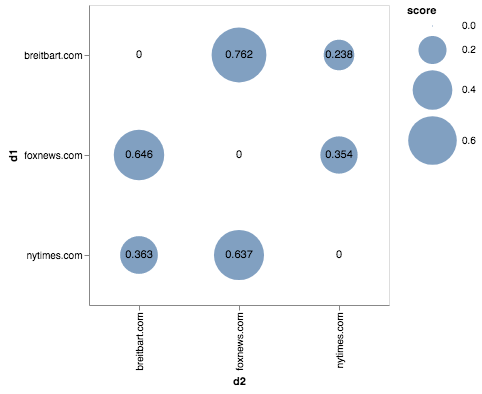

In [170]:
plot_scores(scores)